# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

# Helper Functions

In [ ]:
def report_metrics(train_actual, train_predicted, test_actual, test_predicted):
    train_accuracy = accuracy_score(train_actual, train_predicted)
    test_accuracy = accuracy_score(test_actual, test_predicted)
    precision = precision_score(test_actual, test_predicted)
    recall = recall_score(test_actual, test_predicted)
    confusion = confusion_matrix(test_actual, test_predicted)

    print(f'Train Accuracy:{train_accuracy}\n'
          f'Test Accuracy: {test_accuracy}\n'
          f'Precision: {precision}\n'
          f'Recall: {recall}\n'
          f'Confusion Matrix:\n{confusion}')


def my_roc_auc_score(model, data, label):
    return roc_auc_score(label, model.predict_proba(data)[:, 1])

# Data Preprocessing

In [ ]:
# Preprocess the data
df = pd.read_csv('./diabetes.csv')

# remove the index column
df.drop('Unnamed: 0', axis=1, inplace=True)
# get number of missing values in each column
# print(f'There are {df.isna().any().sum()} Missing Values in the dataset')
df.dropna(inplace=True)

# find whitespaces in each column and rename them
# print(df.columns)
df.rename(columns={
    'High Cholesterol': 'HighCholesterol',
    'Cholesterol Check': 'CholesterolCheck',
    'Physical Activity': 'PhysicalActivity',
    'Heavy Alcohol Consumption': 'HeavyAlcoholConsumption',
    'Any Health Care': 'AnyHealthCare',
    'No Doctor because of Cost': 'NoDoctorBecauseOfCost',
    'General Health': 'GeneralHealth',
    'Mental Health': 'MentalHealth',
    'Physical Health': 'PhysicalHealth',
    'Difficulty Walking': 'DifficultyWalking',
}, inplace=True)
# also find whitespaces in each row and rename them

# get unique values from each feature
# for value in df.columns:
#     print(df[value].unique())
# we can see the 'Very Low' still has whitespaces in it
df = df.replace('Very Low', 'VeryLow')
# we have 'Unknown' in the Income column, so I removed rows with this value
df = df[df['Income'] != 'Unknown']
# make the 'sex' feature binary
df = df.replace('male', np.float64(0))
df = df.replace('female', np.float64(1))

# check if the numeric column needs to be scaled or not
# print(list(set(sorted(df['BMI'].unique().astype(int)))))  # we should categorize
# according to BMI we have: https://www.nhs.uk/common-health-questions/lifestyle/what-is-the-body-mass-index-bmi/
# below 18.5 – you're in the underweight range
# between 18.5 and 24.9 – you're in the healthy weight range
# between 25 and 29.9 – you're in the overweight range
# between 30 and 39.9 – you're in the obese range
# we should categorize the BMI column
df['BMI'] = pd.cut(df['BMI'], (0, 18.5, 24.9, 29.9, 39.9, np.inf), labels=[1, 2, 3, 4, 5])
df['BMI'] = df['BMI'].astype('float')
# print(list(set(sorted(df['MentalHealth'].unique().astype(int)))))  # no need to scale: [0:30]
# print(list(set(sorted(df['PhysicalHealth'].unique().astype(int)))))  # no need to scale: [0:30]
# print(list(set(sorted(df['Age'].unique().astype(int)))))  # no need to scale: [1:13]

# lets one-hot encode the categorical features
df = pd.get_dummies(df, columns=['GeneralHealth', 'Education', 'Income'])

# extract 'Diabetes_binary' as the label
x = df.drop(['Diabetes_binary'], axis=1)
y = df['Diabetes_binary']
# split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)
# scale the numeric value of the train and test
numeric_values = ['BMI', 'MentalHealth', 'PhysicalHealth', 'Age']
scaler = StandardScaler()
x_train[numeric_values] = scaler.fit_transform(x_train[numeric_values])
x_test[numeric_values] = scaler.transform(x_test[numeric_values])

# Train Model

In [ ]:
classifier = XGBClassifier(
    learning_rate=0.1,
    max_depth=4,
    n_estimators=200,
    subsample=0.5,
    colsample_bytree=1,
    random_seed=123,
    eval_metric='auc',
    verbosity=1,
)

classifier.fit(x_train, y_train)
report_metrics(y_train, classifier.predict(x_train), y_test, classifier.predict(x_test))

Train Accuracy:0.7617952889580534
Test Accuracy: 0.7482492749522529
Precision: 0.7275674273858921
Recall: 0.7937473475739143
Confusion Matrix:
[[4967 2101]
 [1458 5611]]


# Fine-Tune Model

In [ ]:
clf = XGBClassifier(eval_metric='auc', sub_sample=0.5)
# print(clf.get_params())
learning_rate_list = [0.02, 0.05, 0.1, 0.3]
max_depth_list = [2, 3, 4]
n_estimators_list = [100, 200, 300]
colsample_bytree_list = [0.8, 1]

parameters = dict(
    learning_rate=learning_rate_list,
    max_depth=max_depth_list,
    n_estimators=n_estimators_list,
    colsample_bytree=colsample_bytree_list
)

k_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=111)
grid_search = GridSearchCV(clf, parameters, scoring=my_roc_auc_score, cv=k_fold)
grid_result = grid_search.fit(x_train, y_train)

print(f'Best Score: {grid_result.best_score_} using parameters: {grid_result.best_params_}')
best_params = grid_result.best_params_
best_params['eval_metric'] = 'auc'
best_params['sub_sample'] = 0.5
best_clf = XGBClassifier(**best_params)
best_clf.fit(x_train, y_train)
report_metrics(y_train, best_clf.predict(x_train), y_test, best_clf.predict(x_test))

Best Score: 0.8291127220021947 using parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Train Accuracy:0.7570913206479452
Test Accuracy: 0.7497347386291292
Precision: 0.7306335728282168
Recall: 0.791201018531617
Confusion Matrix:
[[5006 2062]
 [1476 5593]]


# Visualization

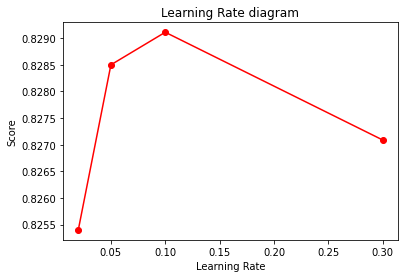

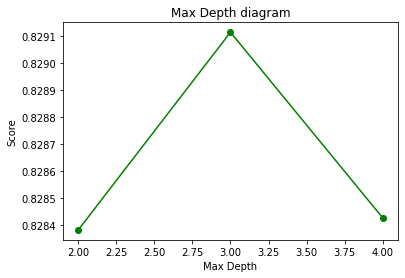

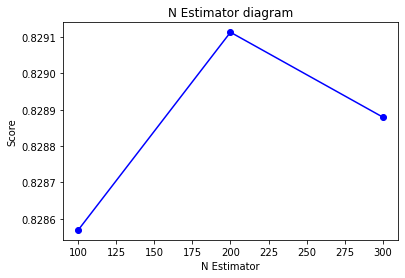

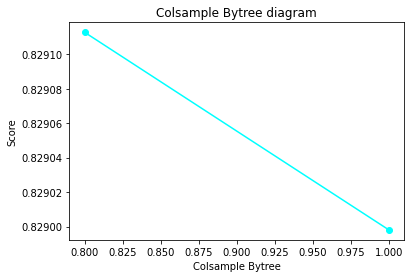

In [ ]:
# Get the result of all combinatoins
learning_rate = grid_result.cv_results_['param_learning_rate']
max_depth = grid_result.cv_results_['param_max_depth']
n_estimator = grid_result.cv_results_['param_n_estimators']
colsample_bytree = grid_result.cv_results_['param_colsample_bytree']
mean_test_score = grid_result.cv_results_['mean_test_score']

results = {}
for i in range(len(mean_test_score)):
    results[learning_rate[i], max_depth[i], n_estimator[i], colsample_bytree[i]] = mean_test_score[i]

# Extracting the best parameters
best_learning_rate = best_params['learning_rate']
best_max_depth = best_params['max_depth']
best_n_estimators = best_params['n_estimators']
best_colsample_bytree = best_params['colsample_bytree']

# get each parameter, with others reamain the same (others are the best parameters that we found in the previous section)
learning_rate_x, learning_rate_y = [], []
max_depth_x, max_depth_y = [], []
n_estimators_x, n_estimators_y = [], []
colsample_bytree_x, colsample_bytree_y = [], []

for key, value in results.items():
  if key[1] == best_max_depth and key[2] == best_n_estimators and key[3] == best_colsample_bytree:
    learning_rate_x.append(key[0])
    learning_rate_y.append(value)
  if key[0] == best_learning_rate and key[2] == best_n_estimators and key[3] == best_colsample_bytree:
    max_depth_x.append(key[1])
    max_depth_y.append(value)
  if key[0] == best_learning_rate and key[1] == best_max_depth and key[3] == best_colsample_bytree:
    n_estimators_x.append(key[2])
    n_estimators_y.append(value)
  if key[0] == best_learning_rate and key[1] == best_max_depth and key[2] == best_n_estimators:
    colsample_bytree_x.append(key[3])
    colsample_bytree_y.append(value)

# plot the parameters
plt.plot(learning_rate_x, learning_rate_y, 'o-', color='red')
plt.title('Learning Rate diagram')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.show()

plt.plot(max_depth_x, max_depth_y, 'o-', color='green')
plt.title('Max Depth diagram')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.show()

plt.plot(n_estimators_x, n_estimators_y, 'o-', color='blue')
plt.title('N Estimator diagram')
plt.xlabel('N Estimator')
plt.ylabel('Score')
plt.show()

plt.plot(colsample_bytree_x, colsample_bytree_y, 'o-', color='cyan')
plt.title('Colsample Bytree diagram')
plt.xlabel('Colsample Bytree')
plt.ylabel('Score')
plt.show()
